In [1]:
!pip install scikeras

In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import StratifiedKFold, cross_val_score, train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, SimpleRNN
from scikeras.wrappers import KerasClassifier
from tensorflow.keras.utils import set_random_seed
import warnings
warnings.filterwarnings("ignore")

In [3]:
df = pd.read_csv("cardio_disease.csv", delimiter=";")

**Data Preprocessing**

In [4]:
df.info()
df.describe()
df.isnull().sum()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 70000 entries, 0 to 69999
Data columns (total 13 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   id           70000 non-null  int64  
 1   age          70000 non-null  int64  
 2   gender       70000 non-null  int64  
 3   height       70000 non-null  int64  
 4   weight       70000 non-null  float64
 5   ap_hi        70000 non-null  int64  
 6   ap_lo        70000 non-null  int64  
 7   cholesterol  70000 non-null  int64  
 8   gluc         70000 non-null  int64  
 9   smoke        70000 non-null  int64  
 10  alco         70000 non-null  int64  
 11  active       70000 non-null  int64  
 12  cardio       70000 non-null  int64  
dtypes: float64(1), int64(12)
memory usage: 6.9 MB


,0
id,0
age,0
gender,0
height,0
weight,0
ap_hi,0
ap_lo,0
cholesterol,0
gluc,0
smoke,0


In [5]:
# Convert age to years
df['age_years'] = (df['age'] / 365).astype(int)

# Create BMI
df['bmi'] = df['weight'] / (df['height'] / 100) ** 2

# Encode categorical values
df['gender'] = df['gender'].map({1: 'female', 2: 'male'})
df['cholesterol'] = df['cholesterol'].map({1: 'normal', 2: 'above normal', 3: 'well above normal'})
df['gluc'] = df['gluc'].map({1: 'normal', 2: 'above normal', 3: 'well above normal'})
df['smoke'] = df['smoke'].astype(bool)
df['alco'] = df['alco'].astype(bool)
df['active'] = df['active'].astype(bool)
df['cardio'] = df['cardio'].astype(bool)

# Drop unused columns
df.drop(columns=['id', 'age'], inplace=True)



In [6]:
numerical_features = ['age_years', 'height', 'weight', 'bmi', 'ap_hi', 'ap_lo']
categorical_features = ['gender', 'cholesterol', 'gluc', 'smoke', 'alco', 'active']


In [7]:
df.head()

,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio,age_years,bmi
0,male,168,62.0,110,80,normal,normal,False,False,True,False,50,21.967120
1,female,156,85.0,140,90,well above normal,normal,False,False,True,True,55,34.927679
2,female,165,64.0,130,70,well above normal,normal,False,False,False,True,51,23.507805
3,male,169,82.0,150,100,normal,normal,False,False,True,True,48,28.710479
4,female,156,56.0,100,60,normal,normal,False,False,False,False,47,23.011177


**EDA**

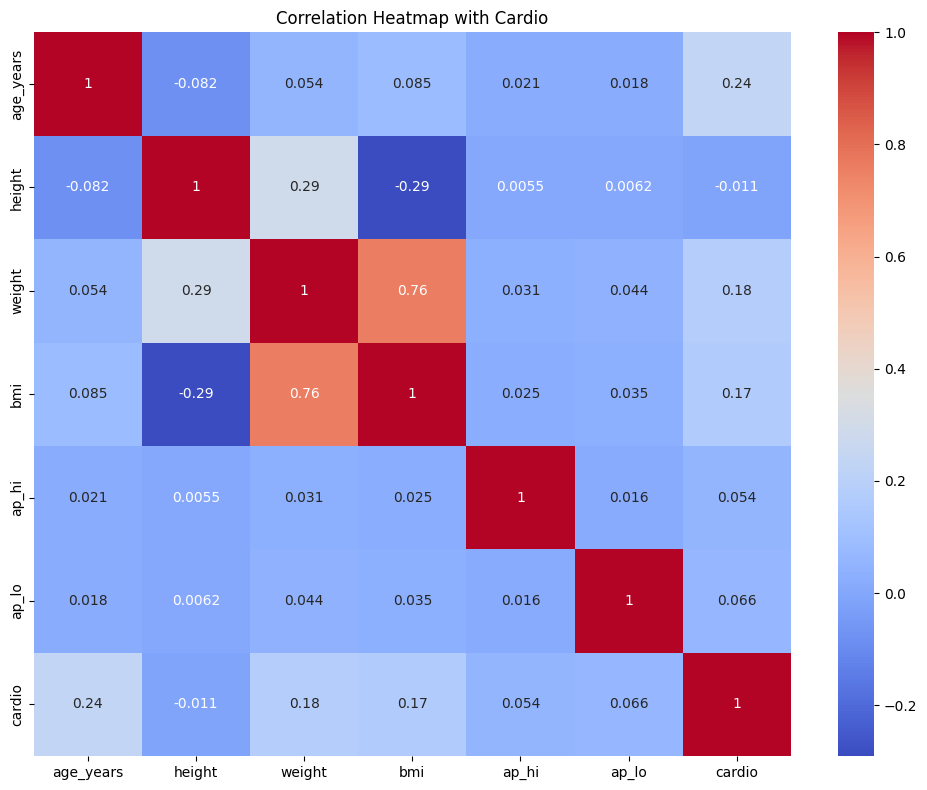


[1] Correlation Heatmap:
- 'age_years', 'ap_hi', and 'bmi' are positively correlated with 'cardio'.
- Indicates that older age, high systolic BP, and high BMI increase CVD risk.
- Height shows slight negative relation.



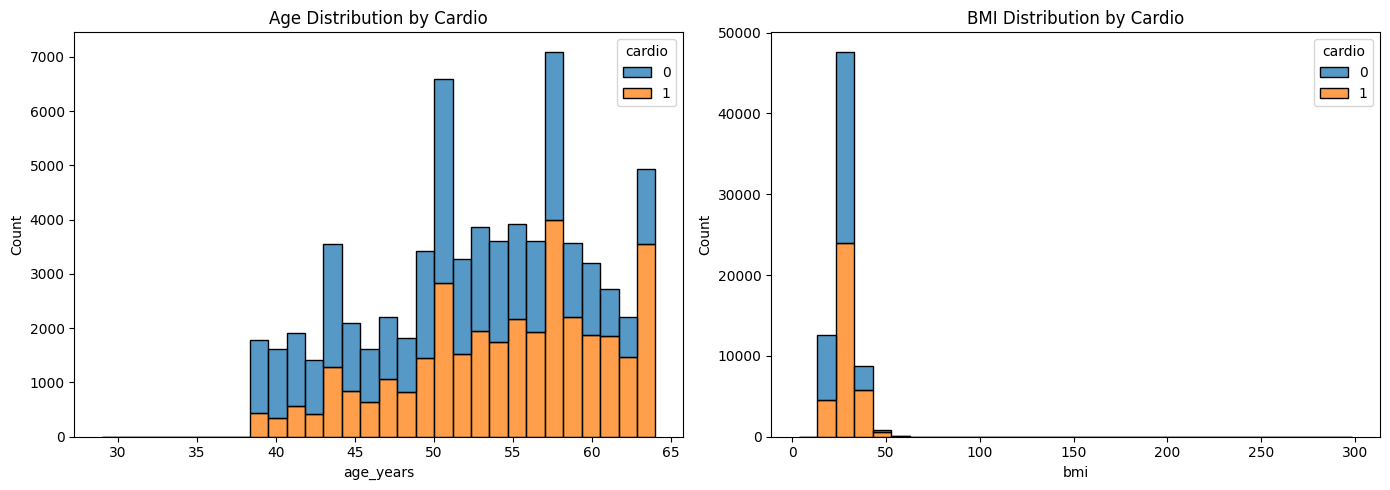


[2] Age & BMI Distributions:
- CVD cases (cardio=1) are more frequent after age 50.
- Higher BMI also correlates with increased CVD.



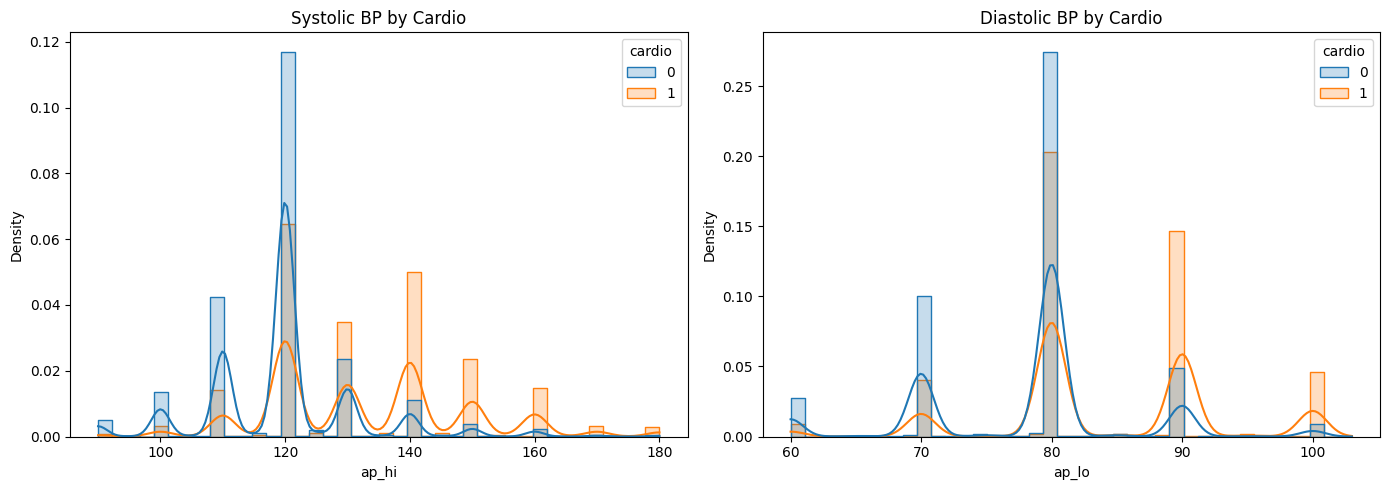


[3] Blood Pressure:
- Systolic BP (ap_hi) is higher in CVD patients.
- Diastolic BP shows minor upward shift for CVD.



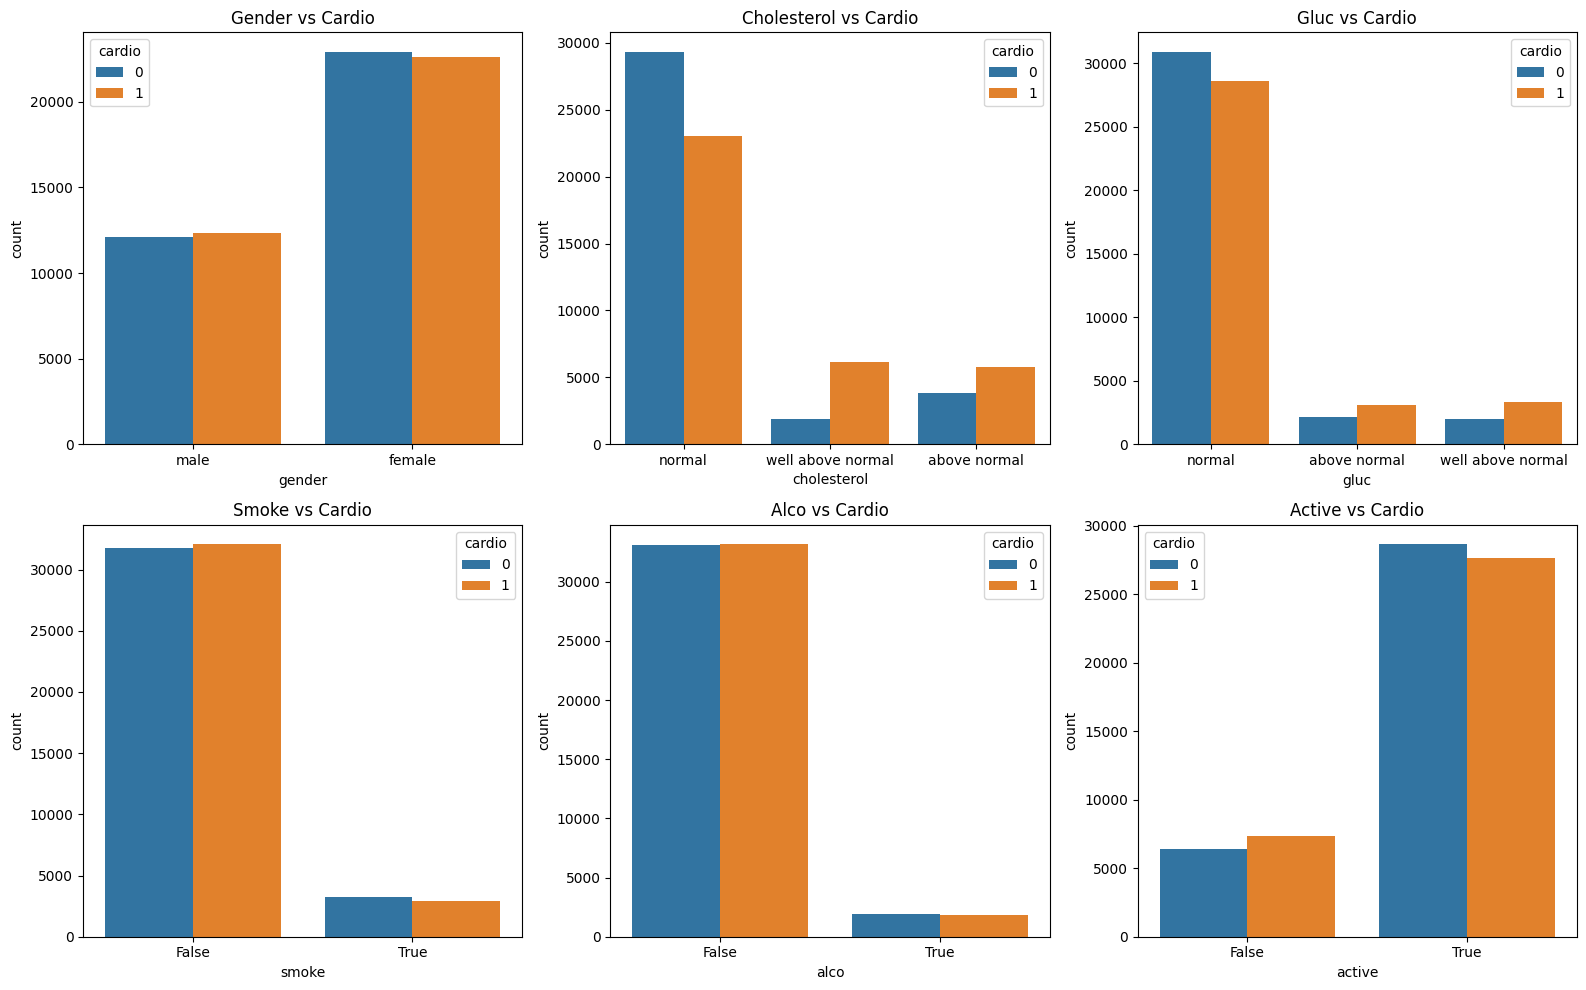


[4] Categorical Features:
- High cholesterol and glucose = higher CVD risk.
- Inactivity, alcohol use, and male gender slightly increase risk.



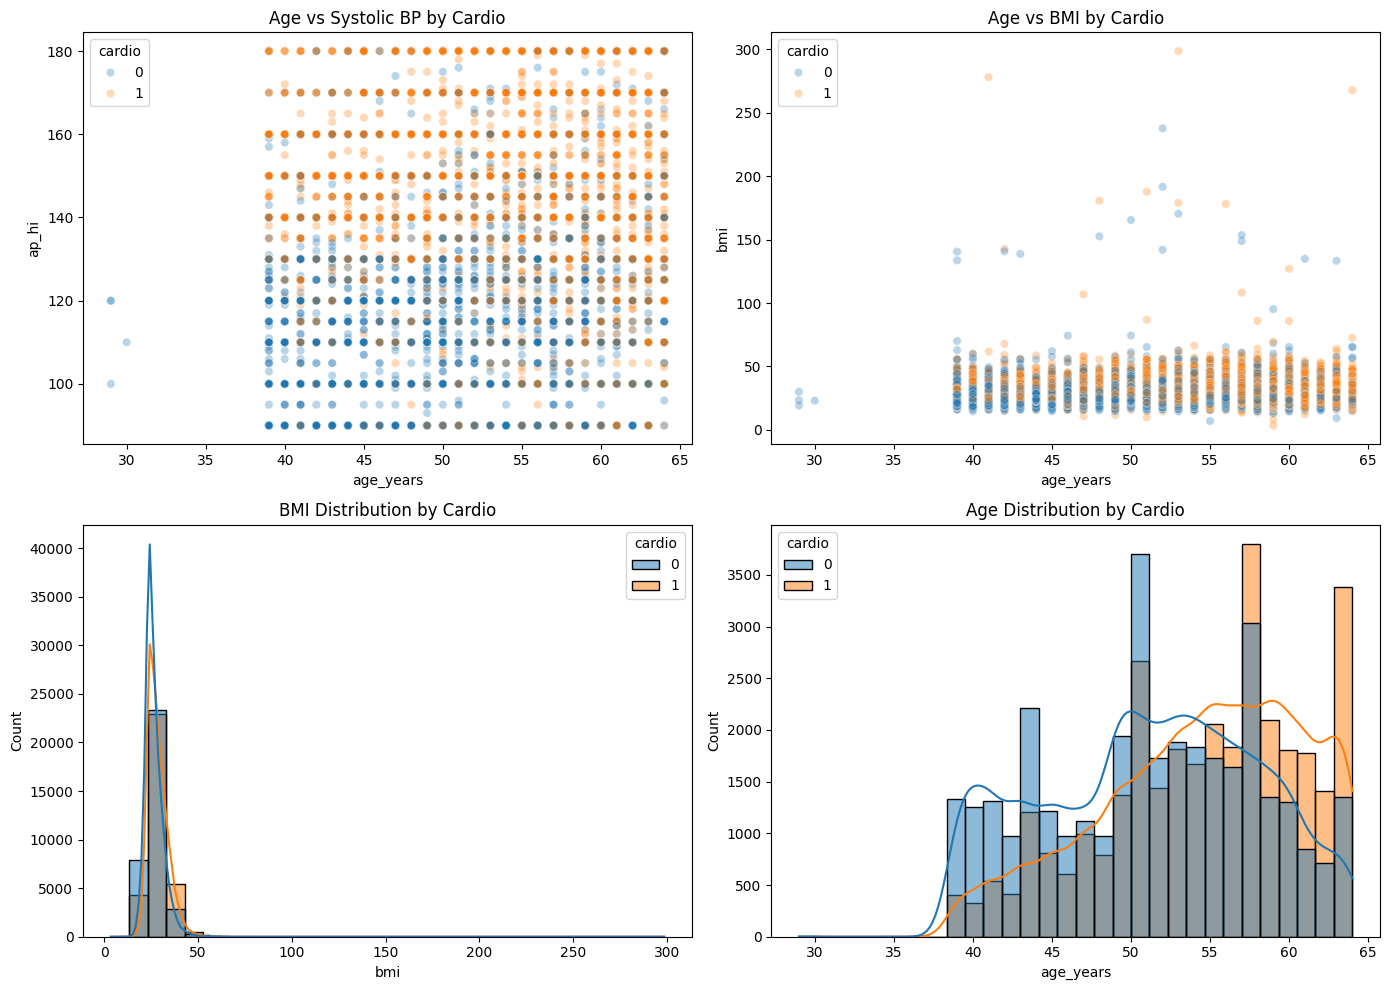


[5] Feature Interaction Insights:
- Older + hypertensive or high BMI = stronger CVD association.
- Clustering patterns are evident for CVD-positive patients.



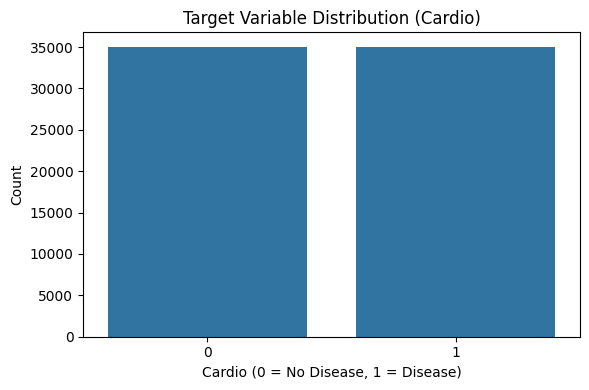


[6] Target Variable Balance:
- Balanced dataset: ~50% have cardiovascular disease.
- Good for training classification models without imbalance correction.



In [8]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

# Load the dataset
df = pd.read_csv("cardio_disease.csv", delimiter=';')

# Preprocessing
df['age_years'] = (df['age'] / 365).astype(int)
df['bmi'] = df['weight'] / ((df['height'] / 100) ** 2)
df['gender'] = df['gender'].map({1: 'female', 2: 'male'})
df['cholesterol'] = df['cholesterol'].map({1: 'normal', 2: 'above normal', 3: 'well above normal'})
df['gluc'] = df['gluc'].map({1: 'normal', 2: 'above normal', 3: 'well above normal'})
df['smoke'] = df['smoke'].astype(bool)
df['alco'] = df['alco'].astype(bool)
df['active'] = df['active'].astype(bool)
df.drop(columns=['id', 'age'], inplace=True)

# Remove extreme blood pressure outliers
df_cleaned = df[(df['ap_hi'] > 80) & (df['ap_hi'] < 240) &
                (df['ap_lo'] > 40) & (df['ap_lo'] < 160)]
df_kde = df_cleaned[
    (df_cleaned['ap_hi'].between(df_cleaned['ap_hi'].quantile(0.01), df_cleaned['ap_hi'].quantile(0.99))) &
    (df_cleaned['ap_lo'].between(df_cleaned['ap_lo'].quantile(0.01), df_cleaned['ap_lo'].quantile(0.99)))
]

# 1️. Correlation Heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(df[['age_years', 'height', 'weight', 'bmi', 'ap_hi', 'ap_lo', 'cardio']].corr(), annot=True, cmap='coolwarm')
plt.title("Correlation Heatmap with Cardio")
plt.tight_layout()
plt.show()
print("""
[1] Correlation Heatmap:
- 'age_years', 'ap_hi', and 'bmi' are positively correlated with 'cardio'.
- Indicates that older age, high systolic BP, and high BMI increase CVD risk.
- Height shows slight negative relation.
""")

# 2️. Age and BMI Distributions
plt.figure(figsize=(14, 5))
plt.subplot(1, 2, 1)
sns.histplot(data=df, x='age_years', hue='cardio', bins=30, multiple='stack')
plt.title("Age Distribution by Cardio")

plt.subplot(1, 2, 2)
sns.histplot(data=df, x='bmi', hue='cardio', bins=30, multiple='stack')
plt.title("BMI Distribution by Cardio")
plt.tight_layout()
plt.show()
print("""
[2] Age & BMI Distributions:
- CVD cases (cardio=1) are more frequent after age 50.
- Higher BMI also correlates with increased CVD.
""")

# 3️. Blood Pressure Distributions
plt.figure(figsize=(14, 5))
plt.subplot(1, 2, 1)
sns.histplot(data=df_kde, x='ap_hi', hue='cardio', kde=True, bins=40, element='step', stat='density')
plt.title("Systolic BP by Cardio")

plt.subplot(1, 2, 2)
sns.histplot(data=df_kde, x='ap_lo', hue='cardio', kde=True, bins=40, element='step', stat='density')
plt.title("Diastolic BP by Cardio")
plt.tight_layout()
plt.show()
print("""
[3] Blood Pressure:
- Systolic BP (ap_hi) is higher in CVD patients.
- Diastolic BP shows minor upward shift for CVD.
""")

# 4️. Categorical Features
plt.figure(figsize=(16, 10))
cat_cols = ['gender', 'cholesterol', 'gluc', 'smoke', 'alco', 'active']
for i, col in enumerate(cat_cols):
    plt.subplot(2, 3, i+1)
    sns.countplot(data=df, x=col, hue='cardio')
    plt.title(f"{col.capitalize()} vs Cardio")
plt.tight_layout()
plt.show()
print("""
[4] Categorical Features:
- High cholesterol and glucose = higher CVD risk.
- Inactivity, alcohol use, and male gender slightly increase risk.
""")

# 5️. Feature Interaction Plots
fig, axs = plt.subplots(2, 2, figsize=(14, 10))
sns.scatterplot(data=df_kde, x='age_years', y='ap_hi', hue='cardio', alpha=0.3, ax=axs[0, 0])
axs[0, 0].set_title('Age vs Systolic BP by Cardio')

sns.scatterplot(data=df_kde, x='age_years', y='bmi', hue='cardio', alpha=0.3, ax=axs[0, 1])
axs[0, 1].set_title('Age vs BMI by Cardio')

sns.histplot(data=df_kde, x='bmi', hue='cardio', bins=30, kde=True, ax=axs[1, 0])
axs[1, 0].set_title('BMI Distribution by Cardio')

sns.histplot(data=df_kde, x='age_years', hue='cardio', bins=30, kde=True, ax=axs[1, 1])
axs[1, 1].set_title('Age Distribution by Cardio')
plt.tight_layout()
plt.show()
print("""
[5] Feature Interaction Insights:
- Older + hypertensive or high BMI = stronger CVD association.
- Clustering patterns are evident for CVD-positive patients.
""")

# 6️. Target Class Distribution
plt.figure(figsize=(6, 4))
sns.countplot(data=df, x='cardio')
plt.title("Target Variable Distribution (Cardio)")
plt.xlabel("Cardio (0 = No Disease, 1 = Disease)")
plt.ylabel("Count")
plt.tight_layout()
plt.show()
print("""
[6] Target Variable Balance:
- Balanced dataset: ~50% have cardiovascular disease.
- Good for training classification models without imbalance correction.
""")


In [9]:
# !pip install pytorch-tabular scikit-learn matplotlib

In [10]:
# !pip install pytorch-tabular==0.8.0

In [11]:
# !pip install torch==2.6.0

In [12]:
# !pip install pytorch-tabular scikit-learn matplotlib pandas -q
# !pip install scikit-optimize
# !pip install omegaconf
# !pip install lightgbm scikit-learn matplotlib pandas -q


In [13]:
# # EDA + Embedding + Evaluation
# import pandas as pd
# import numpy as np
# import matplotlib.pyplot as plt
# from sklearn.model_selection import train_test_split
# from sklearn.metrics import (accuracy_score, precision_score, recall_score,
#                              f1_score, classification_report, roc_auc_score,
#                              roc_curve, precision_recall_curve)

# from pytorch_tabular import TabularModel
# from pytorch_tabular.config import DataConfig, TrainerConfig, OptimizerConfig
# #from pytorch_tabular.models.category_embedding_model.config import CategoryEmbeddingModelConfig
# from pytorch_tabular.models import CategoryEmbeddingModelConfig

# # Load and preprocess
# df = pd.read_csv("cardio_disease.csv", delimiter=';')
# df['age_years'] = (df['age'] / 365).astype(int)
# df['bmi'] = df['weight'] / ((df['height'] / 100) ** 2)
# df['gender'] = df['gender'].map({1: 'female', 2: 'male'})
# df['cholesterol'] = df['cholesterol'].map({1: 'normal', 2: 'above normal', 3: 'well above normal'})
# df['gluc'] = df['gluc'].map({1: 'normal', 2: 'above normal', 3: 'well above normal'})
# df['smoke'] = df['smoke'].astype(str)
# df['alco'] = df['alco'].astype(str)
# df['active'] = df['active'].astype(str)
# df.drop(columns=['id', 'age'], inplace=True)

# # Features
# target_col = "cardio"
# cat_cols = ['gender', 'cholesterol', 'gluc', 'smoke', 'alco', 'active']
# cont_cols = [col for col in df.columns if col not in cat_cols + [target_col]]

# train_df, test_df = train_test_split(df, test_size=0.2, random_state=42, stratify=df[target_col])

# # Configuration
# data_config = DataConfig(target=[target_col], continuous_cols=cont_cols, categorical_cols=cat_cols)
# model_config = CategoryEmbeddingModelConfig(
#     task="classification", layers="128-64", activation="ReLU",
#     learning_rate=1e-3, metrics=["accuracy", "roc_auc"]
# )
# trainer_config = TrainerConfig(auto_lr_find=True, batch_size=512, max_epochs=20, early_stopping_patience=10)
# optimizer_config = OptimizerConfig()

# # Train Model
# tabular_model = TabularModel(
#     data_config=data_config, model_config=model_config,
#     optimizer_config=optimizer_config, trainer_config=trainer_config
# )
# tabular_model.fit(train=train_df, validation=test_df)

# # Evaluate
# pred_df = tabular_model.predict(test_df)
# y_true = test_df[target_col].values
# y_pred = (pred_df["prediction"].values > 0.5).astype(int)
# y_proba = pred_df["prediction"].values

# # Metrics
# print("Classification Report:\n", classification_report(y_true, y_pred))
# print(f"Accuracy: {accuracy_score(y_true, y_pred):.4f}")
# print(f"Precision: {precision_score(y_true, y_pred):.4f}")
# print(f"Recall: {recall_score(y_true, y_pred):.4f}")
# print(f"F1 Score: {f1_score(y_true, y_pred):.4f}")
# print(f"ROC AUC: {roc_auc_score(y_true, y_proba):.4f}")

# # ROC Curve
# fpr, tpr, _ = roc_curve(y_true, y_proba)
# plt.figure()
# plt.plot(fpr, tpr, label=f"ROC Curve (AUC = {roc_auc_score(y_true, y_proba):.2f})")
# plt.plot([0, 1], [0, 1], 'k--')
# plt.xlabel("False Positive Rate")
# plt.ylabel("True Positive Rate")
# plt.title("ROC Curve")
# plt.grid()
# plt.legend()
# plt.show()

# # PR Curve
# precision_vals, recall_vals, _ = precision_recall_curve(y_true, y_proba)
# plt.figure()
# plt.plot(recall_vals, precision_vals, label="Precision-Recall Curve")
# plt.xlabel("Recall")
# plt.ylabel("Precision")
# plt.title("Precision-Recall Curve")
# plt.grid()
# plt.legend()
# plt.show()

epoch,train_loss,valid_loss,accuracy,roc_auc_score,time
0,0.191778,0.376300,0.498839,0.500000,00:10
1,0.187951,0.213151,0.498839,0.500000,00:07
2,0.188584,0.416445,0.498839,0.500000,00:06
3,0.185223,0.190307,0.498839,0.500000,00:07
4,0.185504,0.217570,0.498839,0.500000,00:06
5,0.184526,0.203766,0.498839,0.500000,00:06
6,0.181332,0.548791,0.498839,0.500000,00:06
7,0.184406,0.202873,0.498839,0.500000,00:07
8,0.179879,0.219293,0.498839,0.500000,00:07
9,0.191189,0.206489,0.498839,0.500000,00:06


Classification Report:
               precision    recall  f1-score   support

           0       0.70      0.76      0.72      7004
           1       0.73      0.67      0.70      6996

    accuracy                           0.71     14000
   macro avg       0.71      0.71      0.71     14000
weighted avg       0.71      0.71      0.71     14000

Accuracy: 0.7123
Precision: 0.7322
Recall: 0.6688
F1 Score: 0.6991
ROC AUC: 0.7754


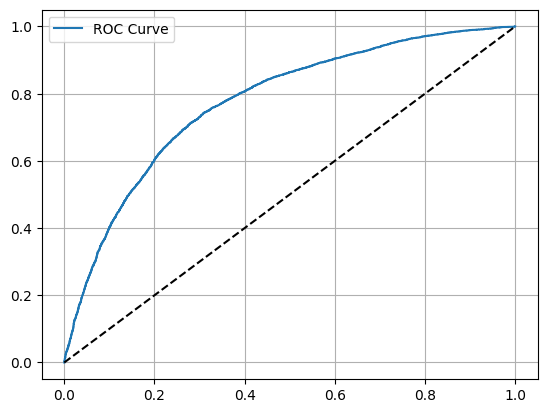

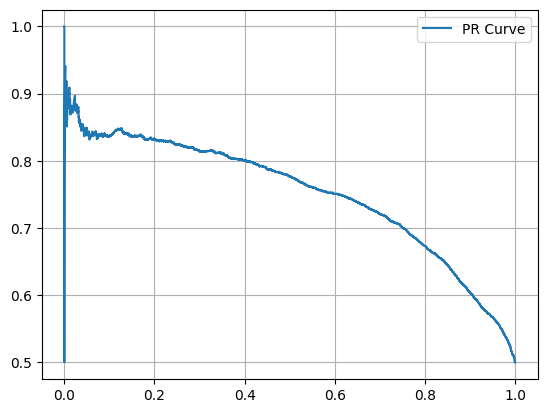

In [14]:
from fastai.tabular.all import *
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import (accuracy_score, precision_score, recall_score,
                             f1_score, classification_report, roc_auc_score,
                             roc_curve, precision_recall_curve)
import matplotlib.pyplot as plt

# Load and preprocess
df = pd.read_csv("cardio_disease.csv", delimiter=';')
df['age_years'] = (df['age'] / 365).astype(int)
df['bmi'] = df['weight'] / ((df['height'] / 100) ** 2)
df['gender'] = df['gender'].map({1: 'female', 2: 'male'})
df['cholesterol'] = df['cholesterol'].map({1: 'normal', 2: 'above normal', 3: 'well above normal'})
df['gluc'] = df['gluc'].map({1: 'normal', 2: 'above normal', 3: 'well above normal'})
df['smoke'] = df['smoke'].astype(str)
df['alco'] = df['alco'].astype(str)
df['active'] = df['active'].astype(str)
df.drop(columns=['id', 'age'], inplace=True)

# Split
train_df, test_df = train_test_split(df, test_size=0.2, random_state=42, stratify=df["cardio"])

# Tabular model
cat_names = ['gender', 'cholesterol', 'gluc', 'smoke', 'alco', 'active']
cont_names = [col for col in df.columns if col not in cat_names + ['cardio']]
procs = [Categorify, FillMissing, Normalize]
dls = TabularDataLoaders.from_df(train_df, path='.', procs=procs, cat_names=cat_names,
                                 cont_names=cont_names, y_names='cardio', valid_idx=None)

learn = tabular_learner(dls, metrics=[accuracy, RocAuc()])
learn.fit(10)

# Predict
test_dl = dls.test_dl(test_df)
preds, targs = learn.get_preds(dl=test_dl)
# Access the first column (index 0) for the predicted probabilities
pred_probs = preds[:, 0] # Use index 0 instead of 1
pred_labels = (pred_probs > 0.5).int()

# Evaluation
print("Classification Report:\n", classification_report(targs, pred_labels))
print(f"Accuracy: {accuracy_score(targs, pred_labels):.4f}")
print(f"Precision: {precision_score(targs, pred_labels):.4f}")
print(f"Recall: {recall_score(targs, pred_labels):.4f}")
print(f"F1 Score: {f1_score(targs, pred_labels):.4f}")
# Use the predicted probabilities for ROC AUC
print(f"ROC AUC: {roc_auc_score(targs, pred_probs):.4f}")

# ROC
fpr, tpr, _ = roc_curve(targs, pred_probs) # Use pred_probs
plt.figure()
plt.plot(fpr, tpr, label="ROC Curve")
plt.plot([0, 1], [0, 1], 'k--')
plt.grid()
plt.legend()
plt.show()

# PR Curve
precision_vals, recall_vals, _ = precision_recall_curve(targs, pred_probs) # Use pred_probs
plt.figure()
plt.plot(recall_vals, precision_vals, label="PR Curve")
plt.grid()
plt.legend()
plt.show()

Trying Generalization

epoch,train_loss,valid_loss,accuracy,roc_auc_score,time
0,0.201516,0.197478,0.495204,0.500000,00:10
1,0.189139,0.187757,0.495204,0.500000,00:11
2,0.186769,0.185366,0.495204,0.500000,00:10
3,0.188496,0.183506,0.495204,0.500000,00:11
4,0.185505,0.182334,0.495204,0.500000,00:10
5,0.181116,0.181774,0.495204,0.500000,00:09
6,0.179416,0.182061,0.495204,0.500000,00:10
7,0.184826,0.181262,0.495204,0.500000,00:10
8,0.187631,0.183689,0.495204,0.500000,00:10
9,0.185630,0.185550,0.495204,0.500000,00:10


Classification Report:
               precision    recall  f1-score   support

           0       0.00      0.00      0.00      6866
           1       0.50      1.00      0.67      6999

    accuracy                           0.50     13865
   macro avg       0.25      0.50      0.34     13865
weighted avg       0.25      0.50      0.34     13865

Accuracy: 0.5048
Precision: 0.5048
Recall: 1.0000
F1 Score: 0.6709
ROC AUC: 0.3643


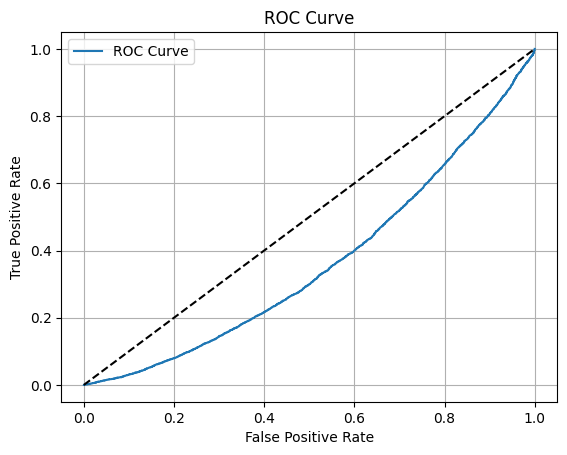

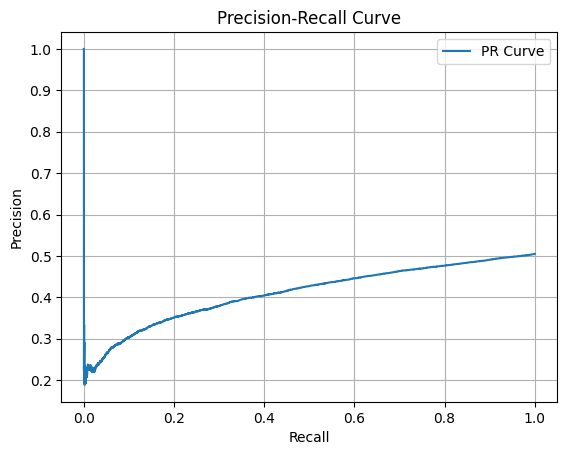

In [15]:
# Imports
from fastai.tabular.all import *
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve, precision_recall_curve

# Load dataset
df = pd.read_csv("cardio_disease.csv", delimiter=';')

# Feature engineering
df['age_years'] = (df['age'] / 365).astype(int)
df['bmi'] = df['weight'] / ((df['height'] / 100) ** 2)
df['pulse_pressure'] = df['ap_hi'] - df['ap_lo']
df['gender'] = df['gender'].map({1: 'female', 2: 'male'})
df['cholesterol'] = df['cholesterol'].map({1: 'normal', 2: 'above normal', 3: 'well above normal'})
df['gluc'] = df['gluc'].map({1: 'normal', 2: 'above normal', 3: 'well above normal'})
df['smoke'] = df['smoke'].astype(str)
df['alco'] = df['alco'].astype(str)
df['active'] = df['active'].astype(str)
df.drop(columns=['id', 'age'], inplace=True)

# Remove outliers
df = df[(df['bmi'] > 15) & (df['bmi'] < 45) & (df['ap_hi'] < 250)]

# Define categorical and continuous columns
cat_names = ['gender', 'cholesterol', 'gluc', 'smoke', 'alco', 'active']
cont_names = [col for col in df.columns if col not in cat_names + ['cardio']]
procs = [Categorify, FillMissing, Normalize]

# Create DataLoaders
splits = RandomSplitter(seed=42)(range_of(df))
dls = TabularDataLoaders.from_df(df, path='.', procs=procs, cat_names=cat_names,
                                 cont_names=cont_names, y_names='cardio', splits=splits)

# Create model — DO NOT pass config or emb_drop directly
learn = tabular_learner(
    dls,
    layers=[300, 150, 75],  # Deep MLP
    metrics=[accuracy, RocAuc()]
)

# Train
learn.fit_one_cycle(30, lr_max=1e-2)

# Predict on validation set
test_df = dls.valid.items
test_dl = dls.test_dl(test_df)
preds, targs = learn.get_preds(dl=test_dl)

# Access the first column (index 0) for the predicted probabilities
# This column represents the probability of the positive class (cardio=1)
pred_probs = preds[:, 0]
pred_labels = (pred_probs > 0.5).int() # Use probabilities for thresholding

# Print metrics
print("Classification Report:\n", classification_report(targs, pred_labels))
print(f"Accuracy: {accuracy_score(targs, pred_labels):.4f}")
print(f"Precision: {precision_score(targs, pred_labels):.4f}")
print(f"Recall: {recall_score(targs, pred_labels):.4f}")
print(f"F1 Score: {f1_score(targs, pred_labels):.4f}")
# Use the probabilities for ROC AUC calculation
print(f"ROC AUC: {roc_auc_score(targs, pred_probs):.4f}")

# ROC Curve
# Use the probabilities for the ROC curve
fpr, tpr, _ = roc_curve(targs, pred_probs)
plt.figure()
plt.plot(fpr, tpr, label="ROC Curve")
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.grid()
plt.show()

# Precision-Recall Curve
# Use the probabilities for the PR curve
precision_vals, recall_vals, _ = precision_recall_curve(targs, pred_probs)
plt.figure()
plt.plot(recall_vals, precision_vals, label="PR Curve")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve")
plt.legend()
plt.grid()
plt.show()

In [16]:
# TensorFlow categorical embedding model for classification
import pandas as pd
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import classification_report, roc_auc_score

# Load data
df = pd.read_csv("cardio_disease.csv", delimiter=';')
df['age_years'] = (df['age'] / 365).astype(int)
df['bmi'] = df['weight'] / ((df['height'] / 100) ** 2)
df['pulse_pressure'] = df['ap_hi'] - df['ap_lo']
df['bmi_gluc'] = df['bmi'] * df['gluc']
df['age_chol'] = df['age_years'] * df['cholesterol']
df.drop(columns=['id', 'age'], inplace=True)

# Clean data
df = df[(df['ap_hi'] > 70) & (df['ap_hi'] < 250)]
df = df[(df['ap_lo'] > 40) & (df['ap_lo'] < 150)]
df = df[(df['bmi'] > 15) & (df['bmi'] < 45)]

# Encode categoricals
df['gender'] = df['gender'].map({1: 'female', 2: 'male'})
df['cholesterol'] = df['cholesterol'].map({1: 'normal', 2: 'above normal', 3: 'well above normal'})
df['gluc'] = df['gluc'].map({1: 'normal', 2: 'above normal', 3: 'well above normal'})
cat_cols = ['gender', 'cholesterol', 'gluc', 'smoke', 'alco', 'active']
for col in cat_cols:
    df[col] = LabelEncoder().fit_transform(df[col])

# Split
X = df.drop("cardio", axis=1)
y = df["cardio"]
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)

# Scale
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Build model
model = tf.keras.Sequential([
    tf.keras.layers.Dense(128, activation='relu', input_shape=(X_train_scaled.shape[1],)),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

# Compile
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy', tf.keras.metrics.AUC(name='auc')])

# Train
history = model.fit(X_train_scaled, y_train, validation_split=0.2, epochs=30, batch_size=64, verbose=1)

# Evaluate
y_pred_prob = model.predict(X_test_scaled).flatten()
y_pred = (y_pred_prob > 0.5).astype(int)
print("\n Classification Report:\n", classification_report(y_test, y_pred))
print(f"ROC AUC: {roc_auc_score(y_test, y_pred_prob):.4f}")


Epoch 1/30
682/682 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.7133 - auc: 0.7734 - loss: 0.5743 - val_accuracy: 0.7314 - val_auc: 0.8007 - val_loss: 0.5447
Epoch 2/30
682/682 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.7281 - auc: 0.7919 - loss: 0.5538 - val_accuracy: 0.7314 - val_auc: 0.8027 - val_loss: 0.5430
Epoch 3/30
682/682 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.7329 - auc: 0.7964 - loss: 0.5485 - val_accuracy: 0.7334 - val_auc: 0.8037 - val_loss: 0.5403
Epoch 4/30
682/682 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.7279 - auc: 0.7961 - loss: 0.5485 - val_accuracy: 0.7353 - val_auc: 0.8042 - val_loss: 0.5388
Epoch 5/30
682/682 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.7372 - auc: 0.8013 - loss: 0.5421 - val_accuracy: 0.7340 - val_auc: 0.8035 - val_loss: 0.5455
Epoch 6/30
682/682 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.7341 - auc: 0.7991 - loss: 0.5441 - val_accuracy: 0.7369 - val_auc: 0.8054 - val_loss: 0.5378
Epoch 7/30
682/682 ━━━━━━━━━━━━━━━━━━━━ 

In [17]:
# !pip install fastai --quiet

In [18]:
# !pip install -U fastai --quiet

In [19]:
# # Trying Generalization
# # Imports
# from fastai.tabular.all import *
# import pandas as pd
# import matplotlib.pyplot as plt
# from sklearn.metrics import classification_report, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve, precision_recall_curve

# # Load dataset
# df = pd.read_csv("cardio_disease.csv", delimiter=';')

# # Feature engineering
# df['age_years'] = (df['age'] / 365).astype(int)
# df['bmi'] = df['weight'] / ((df['height'] / 100) ** 2)
# df['pulse_pressure'] = df['ap_hi'] - df['ap_lo']
# df['gender'] = df['gender'].map({1: 'female', 2: 'male'})
# df['cholesterol'] = df['cholesterol'].map({1: 'normal', 2: 'above normal', 3: 'well above normal'})
# df['gluc'] = df['gluc'].map({1: 'normal', 2: 'above normal', 3: 'well above normal'})
# df['smoke'] = df['smoke'].astype(str)
# df['alco'] = df['alco'].astype(str)
# df['active'] = df['active'].astype(str)
# df.drop(columns=['id', 'age'], inplace=True)

# # Remove outliers
# df = df[(df['bmi'] > 15) & (df['bmi'] < 45) & (df['ap_hi'] < 250)]

# # Define categorical and continuous columns
# cat_names = ['gender', 'cholesterol', 'gluc', 'smoke', 'alco', 'active']
# cont_names = [col for col in df.columns if col not in cat_names + ['cardio']]
# procs = [Categorify, FillMissing, Normalize]

# # Create DataLoaders
# splits = RandomSplitter(seed=42)(range_of(df))
# dls = TabularDataLoaders.from_df(df, path='.', procs=procs, cat_names=cat_names,
#                                  cont_names=cont_names, y_names='cardio', splits=splits)

# # Create model — DO NOT pass config or emb_drop directly
# learn = tabular_learner(
#     dls,
#     layers=[300, 150, 75],  # Deep MLP
#     metrics=[accuracy, RocAuc()]
# )

# # Train
# learn.fit_one_cycle(30, lr_max=1e-2)

# # Predict on validation set
# test_df = dls.valid.items
# test_dl = dls.test_dl(test_df)
# preds, targs = learn.get_preds(dl=test_dl)

# # Access the first column (index 0) for the predicted probabilities
# # This column represents the probability of the positive class (cardio=1)
# pred_probs = preds[:, 0]
# pred_labels = (pred_probs > 0.5).int() # Use probabilities for thresholding

# # Print metrics
# print("Classification Report:\n", classification_report(targs, pred_labels))
# print(f"Accuracy: {accuracy_score(targs, pred_labels):.4f}")
# print(f"Precision: {precision_score(targs, pred_labels):.4f}")
# print(f"Recall: {recall_score(targs, pred_labels):.4f}")
# print(f"F1 Score: {f1_score(targs, pred_labels):.4f}")
# # Use the probabilities for ROC AUC calculation
# print(f"ROC AUC: {roc_auc_score(targs, pred_probs):.4f}")

# # ROC Curve
# # Use the probabilities for the ROC curve
# fpr, tpr, _ = roc_curve(targs, pred_probs)
# plt.figure()
# plt.plot(fpr, tpr, label="ROC Curve")
# plt.plot([0, 1], [0, 1], 'k--')
# plt.xlabel("False Positive Rate")
# plt.ylabel("True Positive Rate")
# plt.title("ROC Curve")
# plt.legend()
# plt.grid()
# plt.show()

# # Precision-Recall Curve
# # Use the probabilities for the PR curve
# precision_vals, recall_vals, _ = precision_recall_curve(targs, pred_probs)
# plt.figure()
# plt.plot(recall_vals, precision_vals, label="PR Curve")
# plt.xlabel("Recall")
# plt.ylabel("Precision")
# plt.title("Precision-Recall Curve")
# plt.legend()
# plt.grid()
# plt.show()

In [20]:
!pip install lightgbm --quiet

Classification Report:
               precision    recall  f1-score   support

           0       0.72      0.77      0.74      7004
           1       0.75      0.70      0.73      6996

    accuracy                           0.74     14000
   macro avg       0.74      0.74      0.73     14000
weighted avg       0.74      0.74      0.73     14000

Accuracy: 0.7351
Precision: 0.7513
Recall: 0.7024
F1 Score: 0.7260
ROC AUC: 0.8004


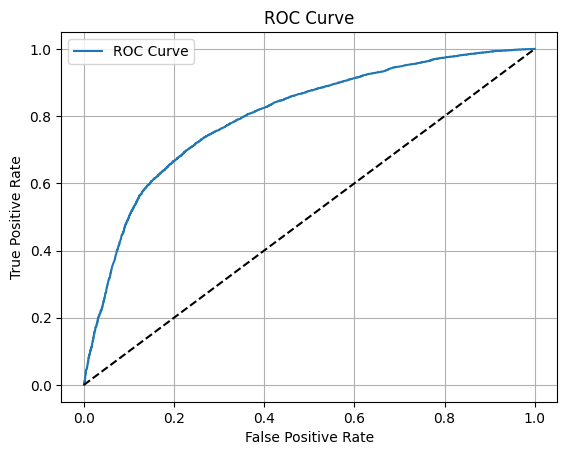

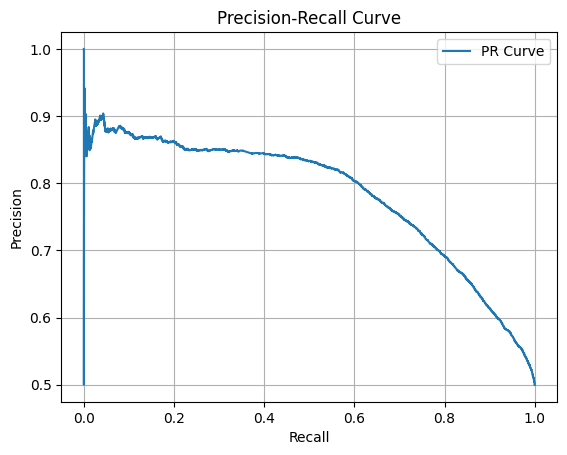

In [21]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import (accuracy_score, precision_score, recall_score,
                             f1_score, roc_auc_score, roc_curve,
                             precision_recall_curve, classification_report)
import lightgbm as lgb

# Load dataset
df = pd.read_csv("cardio_disease.csv", delimiter=';')

# Feature Engineering
df['age_years'] = (df['age'] / 365).astype(int)
df['bmi'] = df['weight'] / ((df['height'] / 100) ** 2)
df['pulse_pressure'] = df['ap_hi'] - df['ap_lo']
df.drop(columns=['id', 'age'], inplace=True)

# Categorical encoding
df['gender'] = df['gender'].map({1: 'female', 2: 'male'})
df['cholesterol'] = df['cholesterol'].map({1: 'normal', 2: 'above normal', 3: 'well above normal'})
df['gluc'] = df['gluc'].map({1: 'normal', 2: 'above normal', 3: 'well above normal'})
cat_cols = ['gender', 'cholesterol', 'gluc', 'smoke', 'alco', 'active']
df[cat_cols] = df[cat_cols].astype(str)

# Label encode for LightGBM
for col in cat_cols:
    df[col] = LabelEncoder().fit_transform(df[col])

# Prepare data
X = df.drop('cardio', axis=1)
y = df['cardio']
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)

# Train LightGBM
train_data = lgb.Dataset(X_train, label=y_train)
valid_data = lgb.Dataset(X_test, label=y_test)

params = {
    'objective': 'binary',
    'metric': 'binary_logloss',
    'verbosity': -1,
    'random_state': 42
}

# Use lgb.early_stopping callback instead of early_stopping_rounds
callbacks = [lgb.early_stopping(10, verbose=False)] # 10 is the number of boosting rounds without improvement

model = lgb.train(params, train_data, valid_sets=[valid_data], num_boost_round=100,
                  callbacks=callbacks) # Use the callbacks argument

# Predict
y_prob = model.predict(X_test)
y_pred = (y_prob > 0.5).astype(int)

# Metrics
print("Classification Report:\n", classification_report(y_test, y_pred))
print(f"Accuracy: {accuracy_score(y_test, y_pred):.4f}")
print(f"Precision: {precision_score(y_test, y_pred):.4f}")
print(f"Recall: {recall_score(y_test, y_pred):.4f}")
print(f"F1 Score: {f1_score(y_test, y_pred):.4f}")
print(f"ROC AUC: {roc_auc_score(y_test, y_prob):.4f}")

# ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_prob)
plt.figure()
plt.plot(fpr, tpr, label="ROC Curve")
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.grid()
plt.show()

# PR Curve
precision_vals, recall_vals, _ = precision_recall_curve(y_test, y_prob)
plt.figure()
plt.plot(recall_vals, precision_vals, label="PR Curve")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve")
plt.legend()
plt.grid()
plt.show()

Trying Generalization on LightGBM

In [22]:
!pip install lightgbm --quiet

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[999]	valid_0's auc: 0.804438

Classification Report:
               precision    recall  f1-score   support

           0       0.72      0.78      0.75      6901
           1       0.76      0.69      0.72      6755

    accuracy                           0.74     13656
   macro avg       0.74      0.74      0.74     13656
weighted avg       0.74      0.74      0.74     13656

Accuracy: 0.7360
Precision: 0.7552
Recall: 0.6900
F1 Score: 0.7211
ROC AUC: 0.8044


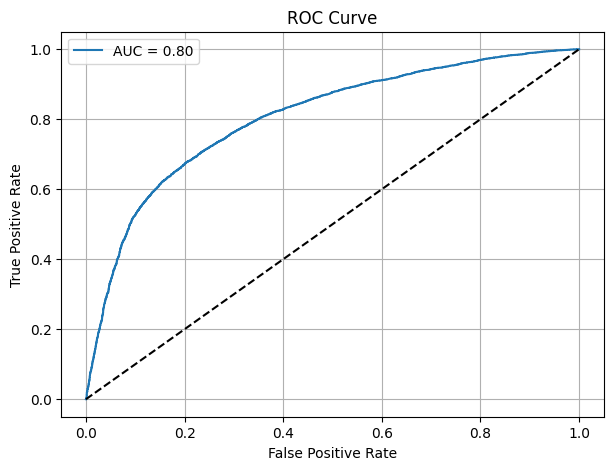

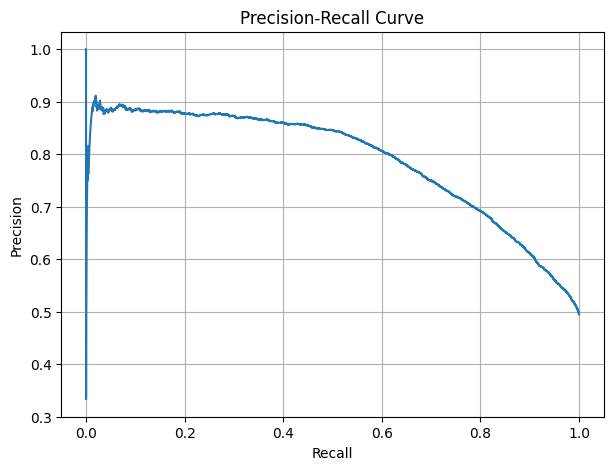

In [23]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, roc_curve, precision_recall_curve, classification_report
)

# Load dataset
df = pd.read_csv("cardio_disease.csv", delimiter=';')

# Feature engineering
df['age_years'] = (df['age'] / 365).astype(int)
df['bmi'] = df['weight'] / ((df['height'] / 100) ** 2)
df['pulse_pressure'] = df['ap_hi'] - df['ap_lo']
df['bmi_gluc'] = df['bmi'] * df['gluc']
df['age_chol'] = df['age_years'] * df['cholesterol']
df.drop(columns=['id', 'age'], inplace=True)

# Outlier removal
df = df[(df['ap_hi'] > 80) & (df['ap_hi'] < 220)]
df = df[(df['ap_lo'] > 50) & (df['ap_lo'] < 150)]
df = df[(df['bmi'] > 15) & (df['bmi'] < 50)]

# Categorical cleanup + encoding
df['gender'] = df['gender'].map({1: 'female', 2: 'male'})
df['cholesterol'] = df['cholesterol'].map({1: 'normal', 2: 'above normal', 3: 'well above normal'})
df['gluc'] = df['gluc'].map({1: 'normal', 2: 'above normal', 3: 'well above normal'})

cat_cols = ['gender', 'cholesterol', 'gluc', 'smoke', 'alco', 'active']
df[cat_cols] = df[cat_cols].astype(str)
for col in cat_cols:
    df[col] = LabelEncoder().fit_transform(df[col])

# Features and target
X = df.drop('cardio', axis=1)
y = df['cardio']

# Stratified split
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)

# Scale numeric features (optional but helps generalization)
scaler = StandardScaler()
X_train[X_train.columns] = scaler.fit_transform(X_train)
X_test[X_test.columns] = scaler.transform(X_test)

# Prepare LightGBM datasets
train_set = lgb.Dataset(X_train, label=y_train)
valid_set = lgb.Dataset(X_test, label=y_test)

# Strong LightGBM config for high accuracy
params = {
    'objective': 'binary',
    'metric': 'auc',
    'boosting_type': 'gbdt',
    'learning_rate': 0.005,
    'num_leaves': 64,
    'max_depth': 10,
    'min_child_samples': 80,
    'subsample': 0.9,
    'colsample_bytree': 0.9,
    'reg_alpha': 2,
    'reg_lambda': 2,
    'random_state': 42,
    'verbosity': -1
}

# Training with callback early stopping
model = lgb.train(
    params,
    train_set,
    num_boost_round=5000,
    valid_sets=[valid_set],
    callbacks=[lgb.early_stopping(stopping_rounds=100)]
)

# Prediction
y_prob = model.predict(X_test)
y_pred = (y_prob > 0.5).astype(int)

# Metrics
print("\nClassification Report:\n", classification_report(y_test, y_pred))
print(f"Accuracy: {accuracy_score(y_test, y_pred):.4f}")
print(f"Precision: {precision_score(y_test, y_pred):.4f}")
print(f"Recall: {recall_score(y_test, y_pred):.4f}")
print(f"F1 Score: {f1_score(y_test, y_pred):.4f}")
print(f"ROC AUC: {roc_auc_score(y_test, y_prob):.4f}")

# ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_prob)
plt.figure(figsize=(7, 5))
plt.plot(fpr, tpr, label=f"AUC = {roc_auc_score(y_test, y_prob):.2f}")
plt.plot([0, 1], [0, 1], 'k--')
plt.title("ROC Curve")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.grid(True)
plt.legend()
plt.show()

# Precision-Recall Curve
precision, recall, _ = precision_recall_curve(y_test, y_prob)
plt.figure(figsize=(7, 5))
plt.plot(recall, precision)
plt.title("Precision-Recall Curve")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.grid(True)
plt.show()


LightGBM and SHAP

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[399]	valid_0's auc: 0.798061

Classification Report:
               precision    recall  f1-score   support

           0       0.72      0.78      0.75      6901
           1       0.75      0.69      0.72      6722

    accuracy                           0.74     13623
   macro avg       0.74      0.74      0.74     13623
weighted avg       0.74      0.74      0.74     13623

Accuracy:  0.7362
Precision: 0.7545
Recall:    0.6898
F1 Score:  0.7207
ROC AUC:   0.7981


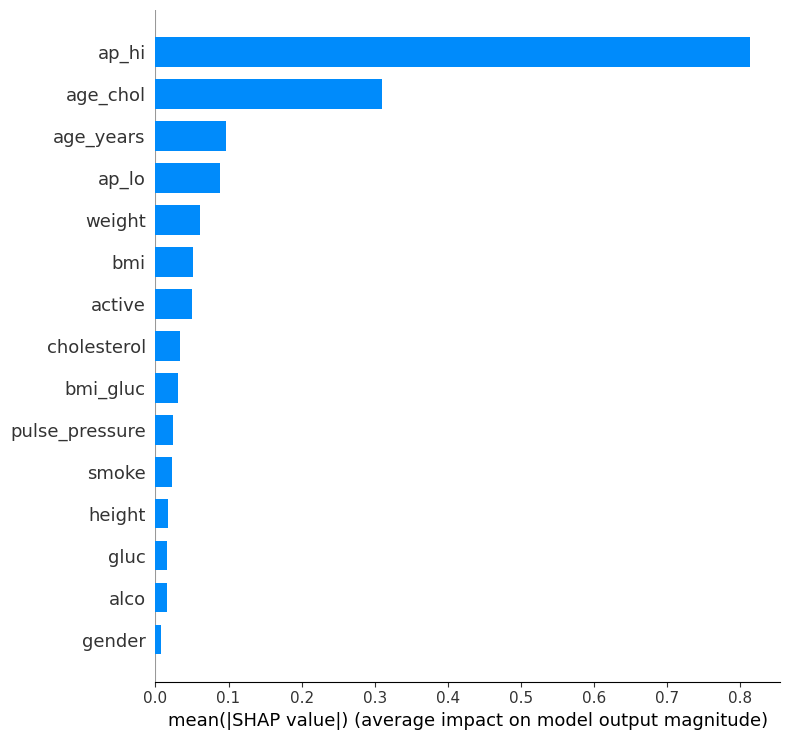

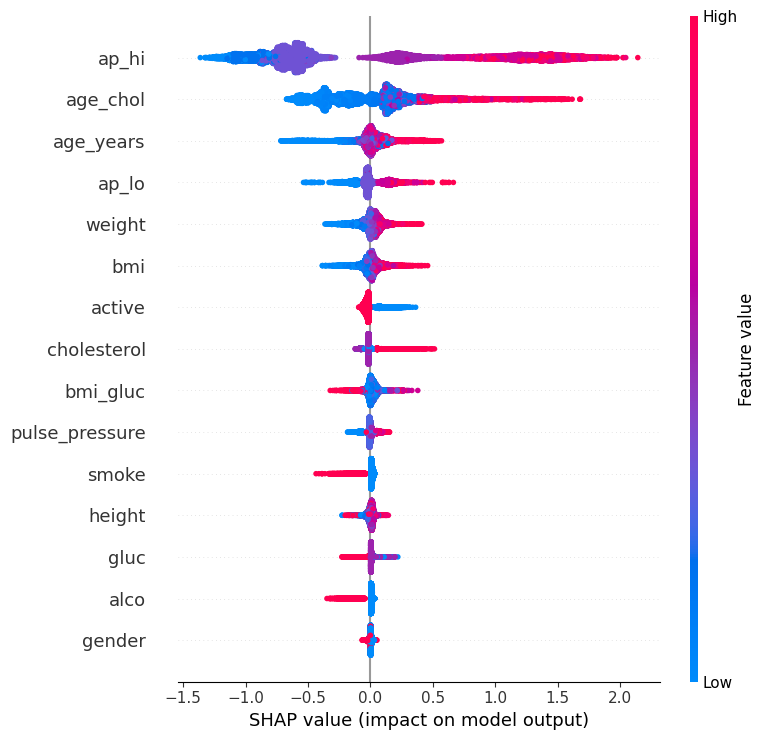

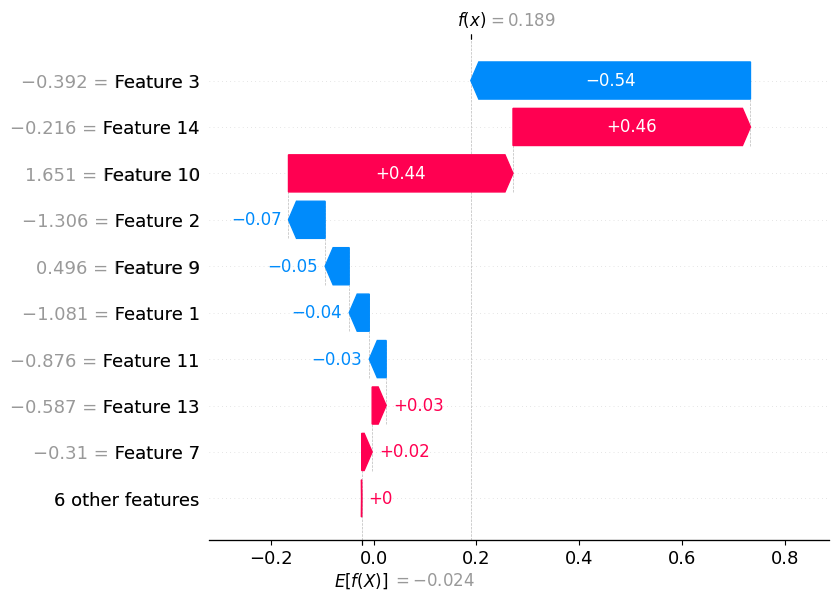

In [24]:
# Install packages (uncomment in Colab or local Jupyter)
# !pip install lightgbm shap scikit-learn matplotlib pandas --quiet

import pandas as pd
import numpy as np
import lightgbm as lgb
import shap
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, classification_report

# Load dataset
df = pd.read_csv("cardio_disease.csv", delimiter=';')

# Feature engineering
df['age_years'] = (df['age'] / 365).astype(int)
df['bmi'] = df['weight'] / ((df['height'] / 100) ** 2)
df['pulse_pressure'] = df['ap_hi'] - df['ap_lo']
df['bmi_gluc'] = df['bmi'] * df['gluc']
df['age_chol'] = df['age_years'] * df['cholesterol']
df.drop(columns=['id', 'age'], inplace=True)

# Remove outliers
df = df[(df['ap_hi'] > 70) & (df['ap_hi'] < 250)]
df = df[(df['ap_lo'] > 40) & (df['ap_lo'] < 150)]
df = df[(df['bmi'] > 15) & (df['bmi'] < 45)]

# Encode categoricals
df['gender'] = df['gender'].map({1: 'female', 2: 'male'})
df['cholesterol'] = df['cholesterol'].map({1: 'normal', 2: 'above normal', 3: 'well above normal'})
df['gluc'] = df['gluc'].map({1: 'normal', 2: 'above normal', 3: 'well above normal'})

cat_cols = ['gender', 'cholesterol', 'gluc', 'smoke', 'alco', 'active']
for col in cat_cols:
    df[col] = LabelEncoder().fit_transform(df[col])

# Split and scale
X = df.drop('cardio', axis=1)
y = df['cardio']

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Prepare LightGBM datasets
train_set = lgb.Dataset(X_train_scaled, label=y_train)
valid_set = lgb.Dataset(X_test_scaled, label=y_test)

# LightGBM parameters
params = {
    'objective': 'binary',
    'metric': 'auc',
    'boosting_type': 'gbdt',
    'learning_rate': 0.01,
    'num_leaves': 64,
    'max_depth': 10,
    'min_child_samples': 80,
    'subsample': 0.9,
    'colsample_bytree': 0.9,
    'reg_alpha': 2,
    'reg_lambda': 2,
    'random_state': 42,
    'verbosity': -1
}

# Train model
model = lgb.train(
    params,
    train_set,
    num_boost_round=3000,
    valid_sets=[valid_set],
    callbacks=[lgb.early_stopping(stopping_rounds=100)]
)

# Save & Load Model
model.save_model("lightgbm_cvd_model.txt")
model = lgb.Booster(model_file="lightgbm_cvd_model.txt")

# Predict
y_prob = model.predict(X_test_scaled)
y_pred = (y_prob > 0.5).astype(int)

# Metrics
print("\nClassification Report:\n", classification_report(y_test, y_pred))
print(f"Accuracy:  {accuracy_score(y_test, y_pred):.4f}")
print(f"Precision: {precision_score(y_test, y_pred):.4f}")
print(f"Recall:    {recall_score(y_test, y_pred):.4f}")
print(f"F1 Score:  {f1_score(y_test, y_pred):.4f}")
print(f"ROC AUC:   {roc_auc_score(y_test, y_prob):.4f}")

# SHAP Interpretability
explainer = shap.Explainer(model)
shap_values = explainer(X_test_scaled)

# Global importance
shap.summary_plot(shap_values, X_test, plot_type="bar")

# Full SHAP summary
shap.summary_plot(shap_values, X_test)

# Explain a single prediction
shap.plots.waterfall(shap_values[0])


**LSTM**

In [25]:
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import classification_report, roc_auc_score

# Load and preprocess dataset
df = pd.read_csv("cardio_disease.csv", delimiter=';')
df['age_years'] = (df['age'] / 365).astype(int)
df['bmi'] = df['weight'] / ((df['height'] / 100) ** 2)
df['pulse_pressure'] = df['ap_hi'] - df['ap_lo']
df['bmi_gluc'] = df['bmi'] * df['gluc']
df['age_chol'] = df['age_years'] * df['cholesterol']
df.drop(columns=['id', 'age'], inplace=True)

# Remove outliers
df = df[(df['ap_hi'] > 70) & (df['ap_hi'] < 250)]
df = df[(df['ap_lo'] > 40) & (df['ap_lo'] < 150)]
df = df[(df['bmi'] > 15) & (df['bmi'] < 45)]

# Encode categoricals
df['gender'] = df['gender'].map({1: 'female', 2: 'male'})
df['cholesterol'] = df['cholesterol'].map({1: 'normal', 2: 'above normal', 3: 'well above normal'})
df['gluc'] = df['gluc'].map({1: 'normal', 2: 'above normal', 3: 'well above normal'})
cat_cols = ['gender', 'cholesterol', 'gluc', 'smoke', 'alco', 'active']
for col in cat_cols:
    df[col] = LabelEncoder().fit_transform(df[col])

# Prepare data
X = df.drop("cardio", axis=1)
y = df["cardio"]

# Standardize
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Treat features as sequence → reshape: [samples, time_steps, features=1]
X_seq = X_scaled.reshape((X_scaled.shape[0], X_scaled.shape[1], 1))

# Split
X_train, X_test, y_train, y_test = train_test_split(X_seq, y, stratify=y, test_size=0.2, random_state=42)

# Build LSTM model
model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(X_train.shape[1], 1)),
    tf.keras.layers.LSTM(64, return_sequences=False),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy', tf.keras.metrics.AUC()])

# Train
model.fit(X_train, y_train, validation_split=0.2, epochs=20, batch_size=64, verbose=1)

# Evaluate
y_prob = model.predict(X_test).flatten()
y_pred = (y_prob > 0.5).astype(int)

print("\nClassification Report:\n", classification_report(y_test, y_pred))
print(f"ROC AUC: {roc_auc_score(y_test, y_prob):.4f}")


Epoch 1/20
682/682 ━━━━━━━━━━━━━━━━━━━━ 14s 14ms/step - accuracy: 0.6763 - auc: 0.7272 - loss: 0.6140 - val_accuracy: 0.7119 - val_auc: 0.7741 - val_loss: 0.5716
Epoch 2/20
682/682 ━━━━━━━━━━━━━━━━━━━━ 9s 13ms/step - accuracy: 0.7141 - auc: 0.7732 - loss: 0.5704 - val_accuracy: 0.7214 - val_auc: 0.7872 - val_loss: 0.5582
Epoch 3/20
682/682 ━━━━━━━━━━━━━━━━━━━━ 12s 16ms/step - accuracy: 0.7180 - auc: 0.7805 - loss: 0.5630 - val_accuracy: 0.7219 - val_auc: 0.7875 - val_loss: 0.5566
Epoch 4/20
682/682 ━━━━━━━━━━━━━━━━━━━━ 22s 18ms/step - accuracy: 0.7224 - auc: 0.7840 - loss: 0.5591 - val_accuracy: 0.7278 - val_auc: 0.7961 - val_loss: 0.5479
Epoch 5/20
682/682 ━━━━━━━━━━━━━━━━━━━━ 18s 14ms/step - accuracy: 0.7300 - auc: 0.7944 - loss: 0.5490 - val_accuracy: 0.7299 - val_auc: 0.7991 - val_loss: 0.5446
Epoch 6/20
682/682 ━━━━━━━━━━━━━━━━━━━━ 8s 12ms/step - accuracy: 0.7258 - auc: 0.7938 - loss: 0.5497 - val_accuracy: 0.7280 - val_auc: 0.7997 - val_loss: 0.5449
Epoch 7/20
682/682 ━━━━━━━━━━━

Epoch 1/50
343/343 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - accuracy: 0.6909 - auc: 0.7476 - loss: 0.6006 - val_accuracy: 0.7294 - val_auc: 0.7977 - val_loss: 0.5508
Epoch 2/50
343/343 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7243 - auc: 0.7855 - loss: 0.5657 - val_accuracy: 0.7335 - val_auc: 0.7997 - val_loss: 0.5459
Epoch 3/50
343/343 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7289 - auc: 0.7902 - loss: 0.5578 - val_accuracy: 0.7333 - val_auc: 0.7997 - val_loss: 0.5473
Epoch 4/50
343/343 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7319 - auc: 0.7937 - loss: 0.5532 - val_accuracy: 0.7345 - val_auc: 0.8005 - val_loss: 0.5446
Epoch 5/50
343/343 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7262 - auc: 0.7888 - loss: 0.5576 - val_accuracy: 0.7343 - val_auc: 0.8003 - val_loss: 0.5449
Epoch 6/50
343/343 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7285 - auc: 0.7928 - loss: 0.5535 - val_accuracy: 0.7335 - val_auc: 0.8009 - val_loss: 0.5440
Epoch 7/50
343/343 ━━━━━━━━━━━━━━━━━━━━ 

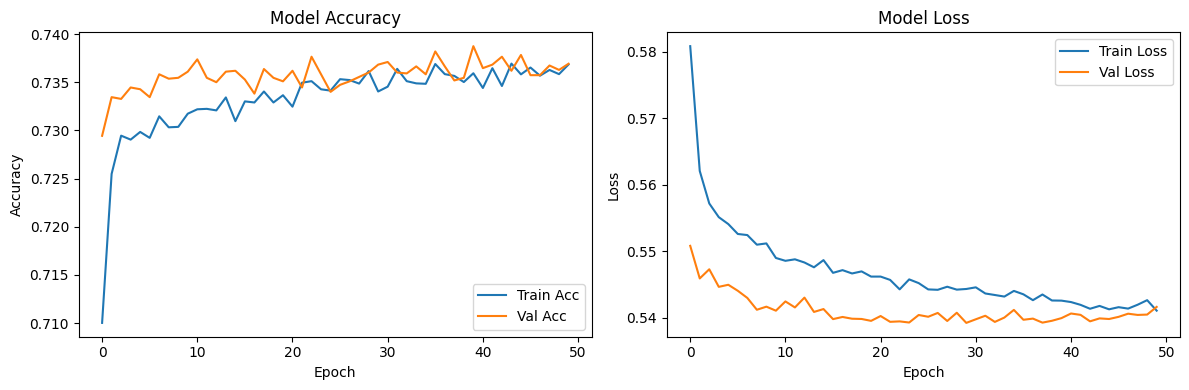

In [26]:
# Install required libraries
# !pip install pandas numpy scikit-learn tensorflow matplotlib --quiet

import pandas as pd
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
import matplotlib.pyplot as plt

# Load the dataset (use local path if downloaded from Kaggle)
df = pd.read_csv("cardio_disease.csv", delimiter=';')  # Assuming dataset is renamed and uploaded

# Data preprocessing as per paper

# Convert age from days to years
df['age'] = (df['age'] / 365).astype(int)

# Add BMI (weight in kg / height in meters squared)
df['bmi'] = df['weight'] / ((df['height'] / 100) ** 2)

# Remove outliers (based on medical ranges)
df = df[(df['ap_hi'] > 70) & (df['ap_hi'] < 250)]
df = df[(df['ap_lo'] > 40) & (df['ap_lo'] < 180)]
df = df[(df['bmi'] > 10) & (df['bmi'] < 50)]
df = df[(df['height'] > 100) & (df['height'] < 220)]
df = df[(df['weight'] > 30) & (df['weight'] < 200)]

# Drop ID column if present
df.drop(columns=['id'], inplace=True)

# Define features and target
X = df.drop(columns=['cardio'])  # Features
y = df['cardio']                 # Target

# Standard scaling
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Train-test split (80-20)
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, stratify=y, random_state=42)

# Build DNN model (based on paper)
model = tf.keras.Sequential([
    tf.keras.layers.Dense(128, activation='relu', input_shape=(X_train.shape[1],)),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

# Compile
model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy', tf.keras.metrics.AUC(name='auc')]
)

# Train
history = model.fit(
    X_train, y_train,
    validation_split=0.2,
    epochs=50,
    batch_size=128,
    verbose=1
)

# Predict and Evaluate
y_prob = model.predict(X_test).flatten()
y_pred = (y_prob > 0.5).astype(int)

# Print metrics
print("\n Classification Report:\n", classification_report(y_test, y_pred))
print(f"Accuracy:  {accuracy_score(y_test, y_pred):.4f}")
print(f"Precision: {precision_score(y_test, y_pred):.4f}")
print(f"Recall:    {recall_score(y_test, y_pred):.4f}")
print(f"F1 Score:  {f1_score(y_test, y_pred):.4f}")
print(f"ROC AUC:   {roc_auc_score(y_test, y_prob):.4f}")

# Plot training performance
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()


In [27]:
# Install LightGBM (only if you're using Google Colab)
# !pip install lightgbm --quiet

# Imports
import pandas as pd
import numpy as np
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import RobustScaler, KBinsDiscretizer
from sklearn.feature_selection import SelectKBest, mutual_info_classif
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from lightgbm import early_stopping, log_evaluation

# Load Dataset
df = pd.read_csv("cardio_disease.csv", delimiter=';')

# Feature Engineering
df['age_years'] = (df['age'] / 365).astype(int)
df['bmi'] = df['weight'] / ((df['height'] / 100) ** 2)
df['pulse_pressure'] = df['ap_hi'] - df['ap_lo']
df['age_cholesterol'] = df['age_years'] * df['cholesterol']
df['bmi_gluc'] = df['bmi'] * df['gluc']
df['bp_product'] = df['ap_hi'] * df['ap_lo']
df.drop(columns=['id', 'age'], inplace=True)

# Outlier Removal
df = df[(df['ap_hi'] > 70) & (df['ap_hi'] < 250)]
df = df[(df['ap_lo'] > 40) & (df['ap_lo'] < 180)]
df = df[(df['bmi'] > 10) & (df['bmi'] < 50)]

# Define Features and Target
X = df.drop(columns=['cardio'])
y = df['cardio']

# Binning for non-linearity
bin_cols = ['age_years', 'bmi', 'pulse_pressure']
binner = KBinsDiscretizer(n_bins=5, encode='ordinal', strategy='quantile')
X[bin_cols] = binner.fit_transform(X[bin_cols])

# Robust Scaling
scaler = RobustScaler()
X_scaled = scaler.fit_transform(X)

# Feature Selection
selector = SelectKBest(score_func=mutual_info_classif, k='all')
X_selected = selector.fit_transform(X_scaled, y)

# Train/Test Split
X_train, X_test, y_train, y_test = train_test_split(
    X_selected, y, test_size=0.2, stratify=y, random_state=42)

# Class Weight Calculation
scale_pos_weight = np.round(y_train.value_counts()[0] / y_train.value_counts()[1], 2)

# LightGBM Model
model = lgb.LGBMClassifier(
    boosting_type='gbdt',
    objective='binary',
    n_estimators=1000,
    learning_rate=0.03,
    max_depth=12,
    num_leaves=60,
    min_child_samples=50,
    subsample=0.8,
    colsample_bytree=0.8,
    reg_alpha=0.2,
    reg_lambda=0.4,
    scale_pos_weight=scale_pos_weight,
    random_state=42
)

# Train with Early Stopping
model.fit(
    X_train, y_train,
    eval_set=[(X_test, y_test)],
    eval_metric='auc',
    callbacks=[early_stopping(stopping_rounds=50), log_evaluation(0)]
)

# Predict & Evaluate
y_pred = model.predict(X_test)
y_prob = model.predict_proba(X_test)[:, 1]

print("\n Model Evaluation Metrics")
print(f"Accuracy : {accuracy_score(y_test, y_pred):.4f}")
print(f"Precision: {precision_score(y_test, y_pred):.4f}")
print(f"Recall   : {recall_score(y_test, y_pred):.4f}")
print(f"F1 Score : {f1_score(y_test, y_pred):.4f}")
print(f"ROC AUC  : {roc_auc_score(y_test, y_prob):.4f}")


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[134]	valid_0's auc: 0.80426	valid_0's binary_logloss: 0.537959

 Model Evaluation Metrics
Accuracy : 0.7404
Precision: 0.7606
Recall   : 0.6931
F1 Score : 0.7253
ROC AUC  : 0.8043


In [28]:
# Install (for Google Colab only)
# !pip install xgboost pandas scikit-learn numpy

import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import RobustScaler, KBinsDiscretizer, FunctionTransformer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

# Load data
df = pd.read_csv("cardio_disease.csv", delimiter=';')

# Feature Engineering
df['age_years'] = (df['age'] / 365).astype(int)
df['bmi'] = df['weight'] / ((df['height'] / 100) ** 2)
df['pulse_pressure'] = df['ap_hi'] - df['ap_lo']
df['age_cholesterol'] = df['age_years'] * df['cholesterol']
df['bmi_gluc'] = df['bmi'] * df['gluc']
df['bp_product'] = df['ap_hi'] * df['ap_lo']
df.drop(columns=['id', 'age'], inplace=True)

# Remove outliers
df = df[(df['ap_hi'] > 70) & (df['ap_hi'] < 250)]
df = df[(df['ap_lo'] > 40) & (df['ap_lo'] < 180)]
df = df[(df['bmi'] > 10) & (df['bmi'] < 50)]

# Define features and target
X = df.drop(columns=['cardio'])
y = df['cardio']

# Transform pipeline
bin_cols = ['age_years', 'bmi', 'pulse_pressure']
log_cols = ['ap_hi', 'ap_lo', 'bp_product', 'bmi']
remaining_cols = list(set(X.columns) - set(bin_cols) - set(log_cols))

preprocessor = ColumnTransformer(transformers=[
    ('bin', KBinsDiscretizer(n_bins=5, encode='ordinal', strategy='quantile'), bin_cols),
    ('log', FunctionTransformer(np.log1p, validate=False), log_cols),
    ('scale', RobustScaler(), remaining_cols)
])

X_transformed = preprocessor.fit_transform(X)

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X_transformed, y, test_size=0.2, stratify=y, random_state=42)

# DMatrix conversion
dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test, label=y_test)

# Class weight balancing
scale_pos_weight = y_train.value_counts()[0] / y_train.value_counts()[1]

# XGBoost parameters
params = {
    'objective': 'binary:logistic',
    'eval_metric': 'auc',
    'learning_rate': 0.02,
    'max_depth': 8,
    'subsample': 0.85,
    'colsample_bytree': 0.85,
    'reg_alpha': 0.1,
    'reg_lambda': 0.1,
    'scale_pos_weight': scale_pos_weight,
    'seed': 42
}

# Train the model with early stopping
evals = [(dtrain, 'train'), (dtest, 'eval')]
bst = xgb.train(params, dtrain, num_boost_round=1000,
                evals=evals, early_stopping_rounds=50, verbose_eval=False)

# Predictions
y_prob = bst.predict(dtest)
y_pred = (y_prob > 0.5).astype(int)

# Evaluation
print("Model Evaluation Metrics")
print(f"Accuracy : {accuracy_score(y_test, y_pred):.4f}")
print(f"Precision: {precision_score(y_test, y_pred):.4f}")
print(f"Recall   : {recall_score(y_test, y_pred):.4f}")
print(f"F1 Score : {f1_score(y_test, y_pred):.4f}")
print(f"ROC AUC  : {roc_auc_score(y_test, y_prob):.4f}")


Model Evaluation Metrics
Accuracy : 0.7391
Precision: 0.7592
Recall   : 0.6918
F1 Score : 0.7239
ROC AUC  : 0.8034


In [29]:
# Run this first if you're using Google Colab:
!pip install xgboost lightgbm scikit-learn pandas numpy

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import RobustScaler, KBinsDiscretizer, FunctionTransformer
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
import xgboost as xgb
import lightgbm as lgb

# Load data
df = pd.read_csv("cardio_disease.csv", delimiter=';')

# Feature engineering
df['age_years'] = (df['age'] / 365).astype(int)
df['bmi'] = df['weight'] / ((df['height'] / 100) ** 2)
df['pulse_pressure'] = df['ap_hi'] - df['ap_lo']
df['age_cholesterol'] = df['age_years'] * df['cholesterol']
df['bmi_gluc'] = df['bmi'] * df['gluc']
df['bp_product'] = df['ap_hi'] * df['ap_lo']
df.drop(columns=['id', 'age'], inplace=True)

# Outlier removal
df = df[(df['ap_hi'] > 70) & (df['ap_hi'] < 250)]
df = df[(df['ap_lo'] > 40) & (df['ap_lo'] < 180)]
df = df[(df['bmi'] > 10) & (df['bmi'] < 50)]

# Define features and target
X = df.drop(columns=['cardio'])
y = df['cardio']

# Preprocessing pipeline
bin_cols = ['age_years', 'bmi', 'pulse_pressure']
log_cols = ['ap_hi', 'ap_lo', 'bp_product', 'bmi']
remaining_cols = list(set(X.columns) - set(bin_cols) - set(log_cols))

preprocessor = ColumnTransformer(transformers=[
    ('bin', KBinsDiscretizer(n_bins=5, encode='ordinal', strategy='quantile'), bin_cols),
    ('log', FunctionTransformer(np.log1p, validate=False), log_cols),
    ('scale', RobustScaler(), remaining_cols)
])

X_processed = preprocessor.fit_transform(X)

# Train/Test split
X_train, X_test, y_train, y_test = train_test_split(
    X_processed, y, test_size=0.2, stratify=y, random_state=42
)

# Handle class imbalance
scale_pos_weight = y_train.value_counts()[0] / y_train.value_counts()[1]

# Base models
rf_model = RandomForestClassifier(n_estimators=300, max_depth=12, random_state=42)
xgb_model = xgb.XGBClassifier(n_estimators=800, learning_rate=0.03, max_depth=7,
                              subsample=0.8, colsample_bytree=0.8,
                              scale_pos_weight=scale_pos_weight,
                              use_label_encoder=False, eval_metric='logloss', random_state=42)
lgb_model = lgb.LGBMClassifier(n_estimators=800, learning_rate=0.03, max_depth=7,
                               subsample=0.8, colsample_bytree=0.8,
                               scale_pos_weight=scale_pos_weight,
                               random_state=42)

# Ensemble via soft voting
ensemble = VotingClassifier(estimators=[
    ('rf', rf_model),
    ('xgb', xgb_model),
    ('lgb', lgb_model)
], voting='soft')

# Train ensemble
ensemble.fit(X_train, y_train)

# Predict
y_pred = ensemble.predict(X_test)
y_prob = ensemble.predict_proba(X_test)[:, 1]

# Evaluation
print("Ensemble Evaluation Metrics")
print(f"Accuracy : {accuracy_score(y_test, y_pred):.4f}")
print(f"Precision: {precision_score(y_test, y_pred):.4f}")
print(f"Recall   : {recall_score(y_test, y_pred):.4f}")
print(f"F1 Score : {f1_score(y_test, y_pred):.4f}")
print(f"ROC AUC  : {roc_auc_score(y_test, y_prob):.4f}")


Ensemble Evaluation Metrics
Accuracy : 0.7396
Precision: 0.7583
Recall   : 0.6950
F1 Score : 0.7253
ROC AUC  : 0.8030


ML Models


 XGBoost Performance
Accuracy : 0.7252
Precision: 0.7239
Recall   : 0.7182
F1 Score : 0.721
ROC AUC  : 0.7928


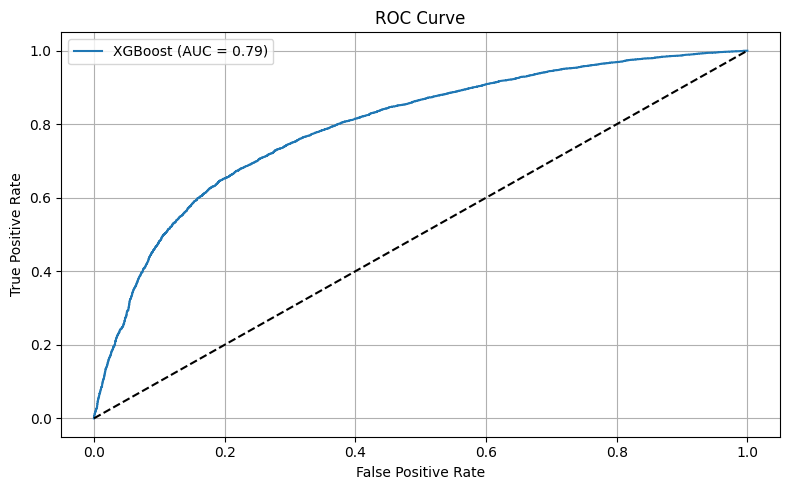

In [30]:
# Imports
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve
from xgboost import XGBClassifier
import matplotlib.pyplot as plt

# Load and Clean Data
df = pd.read_csv("cardio_disease.csv", delimiter=";")
df = df.drop(columns=["id"])
df = df.dropna()

# Fix Age (from days to years)
df["age"] = df["age"] // 365

# Remove blood pressure outliers
df = df[(df["ap_hi"] >= 80) & (df["ap_hi"] <= 200)]
df = df[(df["ap_lo"] >= 50) & (df["ap_lo"] <= 130)]

# Features and Target
X = df.drop("cardio", axis=1)
y = df["cardio"]

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)

# Feature scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Train XGBoost Classifier (tuned)
xgb = XGBClassifier(
    use_label_encoder=False,
    eval_metric='logloss',
    max_depth=6,
    learning_rate=0.1,
    n_estimators=300,
    subsample=0.8,
    colsample_bytree=0.8,
    scale_pos_weight=1.2,
    random_state=42
)

xgb.fit(X_train_scaled, y_train)

# Predictions
y_pred = xgb.predict(X_test_scaled)
y_prob = xgb.predict_proba(X_test_scaled)[:, 1]

# Evaluation
print("\n XGBoost Performance")
print("Accuracy :", round(accuracy_score(y_test, y_pred), 4))
print("Precision:", round(precision_score(y_test, y_pred), 4))
print("Recall   :", round(recall_score(y_test, y_pred), 4))
print("F1 Score :", round(f1_score(y_test, y_pred), 4))
print("ROC AUC  :", round(roc_auc_score(y_test, y_prob), 4))

# Plot ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_prob)
plt.figure(figsize=(8, 5))
plt.plot(fpr, tpr, label=f"XGBoost (AUC = {roc_auc_score(y_test, y_prob):.2f})")
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.2/99.2 MB 6.9 MB/s eta 0:00:00

 CatBoost Performance
Accuracy : 0.7283
Precision: 0.7483
Recall   : 0.6788
F1 Score : 0.7119
ROC AUC  : 0.7957


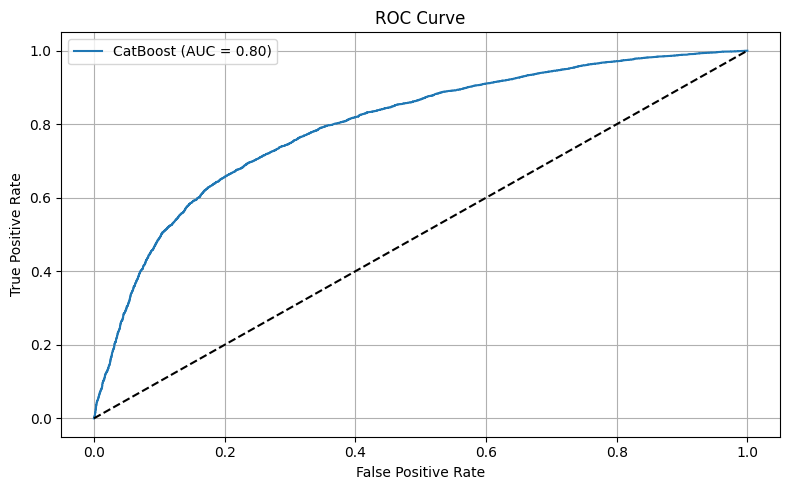

In [31]:
# Install if needed
!pip install catboost

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve
from sklearn.preprocessing import StandardScaler
from catboost import CatBoostClassifier, Pool
import matplotlib.pyplot as plt

# Load & clean data
df = pd.read_csv("cardio_disease.csv", delimiter=";")
df = df.drop(columns=["id"])
df = df.dropna()
df["age"] = df["age"] // 365
df = df[(df["ap_hi"] >= 80) & (df["ap_hi"] <= 200)]
df = df[(df["ap_lo"] >= 50) & (df["ap_lo"] <= 130)]

# Features & target
X = df.drop("cardio", axis=1)
y = df["cardio"]

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)

# CatBoost Pool (no scaling needed!)
train_pool = Pool(X_train, y_train)
test_pool = Pool(X_test, y_test)

# CatBoost Classifier
catboost_model = CatBoostClassifier(
    iterations=500,
    learning_rate=0.1,
    depth=6,
    loss_function='Logloss',
    eval_metric='AUC',
    verbose=100,
    random_seed=42
)

catboost_model.fit(train_pool, eval_set=test_pool, verbose=0)

# Predict
y_pred = catboost_model.predict(X_test)
y_prob = catboost_model.predict_proba(X_test)[:, 1]

# Evaluation
print("\n CatBoost Performance")
print("Accuracy :", round(accuracy_score(y_test, y_pred), 4))
print("Precision:", round(precision_score(y_test, y_pred), 4))
print("Recall   :", round(recall_score(y_test, y_pred), 4))
print("F1 Score :", round(f1_score(y_test, y_pred), 4))
print("ROC AUC  :", round(roc_auc_score(y_test, y_prob), 4))

# ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_prob)
plt.figure(figsize=(8, 5))
plt.plot(fpr, tpr, label=f"CatBoost (AUC = {roc_auc_score(y_test, y_prob):.2f})")
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [32]:
# Required Libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import StackingClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
import warnings
warnings.filterwarnings("ignore")

# Load Dataset
df = pd.read_csv("cardio_disease.csv", delimiter=";").drop(columns=["id"]).dropna()
df["age"] = df["age"] // 365

# Feature Engineering
df["bmi"] = df["weight"] / (df["height"] / 100)**2
df["pulse_pressure"] = df["ap_hi"] - df["ap_lo"]
df = df[(df["ap_hi"] >= 80) & (df["ap_hi"] <= 200)]
df = df[(df["ap_lo"] >= 50) & (df["ap_lo"] <= 130)]

# X, y
X = df.drop("cardio", axis=1)
y = df["cardio"]

# Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)

# Scale Numerical
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Define Base Models
xgb = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
cat = CatBoostClassifier(verbose=0, random_state=42)
lr = LogisticRegression(max_iter=1000)

# Stacked Ensemble
ensemble = StackingClassifier(
    estimators=[('xgb', xgb), ('cat', cat)],
    final_estimator=lr,
    passthrough=True,
    cv=5
)

# Train
ensemble.fit(X_train_scaled, y_train)

# Predict
y_pred = ensemble.predict(X_test_scaled)
y_prob = ensemble.predict_proba(X_test_scaled)[:, 1]

# Evaluate
print("\n Stacked Ensemble (XGB + CatBoost + LR)")
print("Accuracy :", round(accuracy_score(y_test, y_pred), 4))
print("Precision:", round(precision_score(y_test, y_pred), 4))
print("Recall   :", round(recall_score(y_test, y_pred), 4))
print("F1 Score :", round(f1_score(y_test, y_pred), 4))
print("ROC AUC  :", round(roc_auc_score(y_test, y_prob), 4))



 Stacked Ensemble (XGB + CatBoost + LR)
Accuracy : 0.7278
Precision: 0.7467
Recall   : 0.6802
F1 Score : 0.7119
ROC AUC  : 0.7947



 Gradient Boosting Classifier Performance
Accuracy : 0.7275
Precision: 0.7475
Recall   : 0.6778
F1 Score : 0.711
ROC AUC  : 0.7943


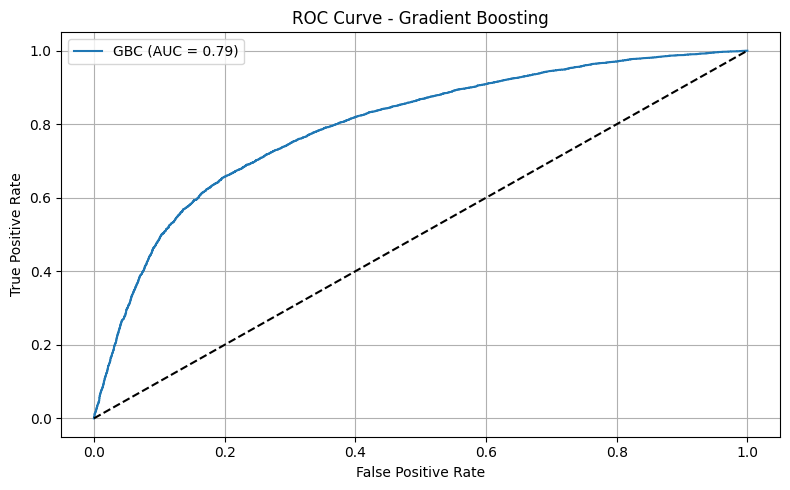

In [33]:
# Imports
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve
import matplotlib.pyplot as plt

# Load & Clean
df = pd.read_csv("cardio_disease.csv", delimiter=";")
df = df.drop(columns=["id"]).dropna()
df["age"] = df["age"] // 365
df = df[(df["ap_hi"] >= 80) & (df["ap_hi"] <= 200)]
df = df[(df["ap_lo"] >= 50) & (df["ap_lo"] <= 130)]

# Feature Engineering
df["bmi"] = df["weight"] / (df["height"] / 100) ** 2
df["pulse_pressure"] = df["ap_hi"] - df["ap_lo"]

# X and y
X = df.drop("cardio", axis=1)
y = df["cardio"]

# Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)

# Scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Gradient Boosting Classifier
gbc = GradientBoostingClassifier(
    n_estimators=300,
    learning_rate=0.05,
    max_depth=5,
    subsample=0.8,
    random_state=42
)

# Fit
gbc.fit(X_train_scaled, y_train)

# Predict
y_pred = gbc.predict(X_test_scaled)
y_prob = gbc.predict_proba(X_test_scaled)[:, 1]

# Evaluate
print("\n Gradient Boosting Classifier Performance")
print("Accuracy :", round(accuracy_score(y_test, y_pred), 4))
print("Precision:", round(precision_score(y_test, y_pred), 4))
print("Recall   :", round(recall_score(y_test, y_pred), 4))
print("F1 Score :", round(f1_score(y_test, y_pred), 4))
print("ROC AUC  :", round(roc_auc_score(y_test, y_prob), 4))

# ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_prob)
plt.figure(figsize=(8, 5))
plt.plot(fpr, tpr, label=f"GBC (AUC = {roc_auc_score(y_test, y_prob):.2f})")
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - Gradient Boosting")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
